# Medical Imaging Augmentation using Generative AI (GANs, VAE) + AR Demo


## Part 1 — Installing libraries: what & why

**Goal:** Install the Python packages required for this workshop and explain why each is needed.

**Detailed explanation:**

- `torch` and `torchvision`: the core deep learning framework used for building GANs, VAEs, and ResNets. PyTorch is flexible and popular in research.
- `kaggle`: CLI to download datasets from Kaggle programmatically using your API key (`kaggle.json`).
- `timm`: a model hub for high-quality vision models (ResNet variants). We will use ResNet18 from `timm`.
- `mediapipe`: provides efficient real-time perception modules (hands/face) used for the AR demo.
- `scikit-learn`, `matplotlib`, `pandas`: utilities for evaluation, plotting, and metrics.

Run the cell below to install these packages in Colab. If a package is already present, pip will skip or upgrade it.

In [1]:
# ================================
# 📌 CELL 1 — Install Everything Cleanly (Colab-safe)
# ================================

# Fix protobuf to a supported version BEFORE installing mediapipe
!pip install --upgrade pip --quiet
!pip install protobuf==3.20.* --quiet

# Install Kaggle for dataset download
!pip install kaggle --quiet

# Install timm for ResNet models
!pip install timm --quiet

# Install MediaPipe safely
!pip install mediapipe==0.10.14 --quiet

# Install albumentations for augmentation
!pip install albumentations==1.4.7 --quiet

# Install utility libraries
!pip install scikit-learn matplotlib pandas tqdm --quiet

print("✅ All libraries installed successfully!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires p

## Part 2 — Kaggle and `kaggle.json`: what is it and how to use it

**What is Kaggle?** Kaggle is a platform for datasets and competitions. Many public datasets are stored there.

**What is `kaggle.json`?** It's an API credential file containing your Kaggle username and API key. Example format:

```
{ "username": "your_kaggle_username", "key": "your_api_key" }
```

**Why do we need it?** To programmatically download datasets (so students don't manually download/upload zip files). Keep it secret!

**Security best practices:**
- Do not commit `kaggle.json` to public repos.
- Delete the file from the Colab session after use (we show how).

Below are the exact commands to upload your `kaggle.json` to Colab and configure it. A detailed explanation follows the commands.

In [2]:
# Upload kaggle.json (this opens a file dialog in Colab).
from google.colab import files
print('Please upload your kaggle.json (Kaggle API token). Get it from https://www.kaggle.com/settings/account -> Create API Token')
uploaded = files.upload()  # Upload prompt

# After uploading, move it to ~/.kaggle and set permissions
import os
if 'kaggle.json' in uploaded:
    os.makedirs('/root/.kaggle', exist_ok=True)
    with open('/root/.kaggle/kaggle.json', 'wb') as f:
        f.write(uploaded['kaggle.json'])
    os.chmod('/root/.kaggle/kaggle.json', 0o600)
    print('kaggle.json saved to /root/.kaggle/.')
else:
    print('kaggle.json not found in upload. Please repeat the cell and upload the file.')

# Explanation:
# - files.upload opens a browser file picker in Colab. Upload the kaggle.json you downloaded from your Kaggle account.
# - We move it to /root/.kaggle which is the standard location that the `kaggle` CLI expects.
# - chmod 600 restricts file permissions so the key isn't world-readable.


Please upload your kaggle.json (Kaggle API token). Get it from https://www.kaggle.com/settings/account -> Create API Token


Saving kaggle.json to kaggle.json
kaggle.json saved to /root/.kaggle/.


## Part 3 — Download Chest X-Ray Pneumonia dataset (Paul Mooney) from Kaggle

**Dataset summary:**
- Name: Chest X-Ray Images (Pneumonia)
- Source: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
- Structure: `train/val/test` directories with `NORMAL` and `PNEUMONIA` subfolders.

**Medical background (concise):**
- Pneumonia is an infection that inflames air sacs (alveoli). Radiologically, it appears as areas of opacity (cloudiness) in the lungs.
- Use this dataset to build a binary classification model: NORMAL vs PNEUMONIA.

**Why resize to 64×64 or 128×128?**
- GANs are easier to train at lower resolutions for live demos. Choose 64×64 for speed; 128×128 for better fidelity (longer training).

Run the cell to download and unzip. The `kaggle` CLI will use the uploaded `kaggle.json` credentials.

In [3]:
# Download dataset via Kaggle CLI and unzip
import os
dataset_id = 'paultimothymooney/chest-xray-pneumonia'
data_dir = './data'
os.makedirs(data_dir, exist_ok=True)

# Download (if not already present)
if not os.path.exists(os.path.join(data_dir, 'chest_xray')):
    print('Downloading dataset from Kaggle (this may take a minute)...')
    !kaggle datasets download -d {dataset_id} -p {data_dir}
    !unzip -q {data_dir}/chest-xray-pneumonia.zip -d {data_dir}
    print('Download and unzip complete.')
else:
    print('Dataset already present.')

# Quick check of folder structure
for split in ['train','val','test']:
    p = os.path.join(data_dir,'chest_xray',split)
    if os.path.exists(p):
        n_files = sum([len(files) for _, _, files in os.walk(p)])
        print(f'{split}: {n_files} files under {p}')
    else:
        print(f'{p} not found - please verify dataset presence.')

# Explanation:
# - We check if dataset folder exists to avoid re-downloading.
# - The downloaded zip is unzipped into ./data/chest_xray/ which mimics the ImageFolder expectation.


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.26G/2.29G [00:31<00:01, 24.7MB/s]
100% 2.29G/2.29G [00:31<00:00, 78.0MB/s]
Download and unzip complete.
train: 5216 files under ./data/chest_xray/train
val: 16 files under ./data/chest_xray/val
test: 624 files under ./data/chest_xray/test


## Part 4 — Loading dataset into PyTorch and applying transforms

**Concepts:**
- `ImageFolder`: expects a root directory with subfolders per class. Each subfolder contains images of that class.
- `Transforms`: preprocessing steps (resize, grayscale, tensor conversion, normalization).
- `DataLoader`: produces batches for training.

**Why normalize and why to which range?**
- For DCGAN we use `Tanh` (generator outputs in [-1,1]) so we will map images from [0,1] to [-1,1] when feeding the GAN.
- For classifier (ResNet) we usually keep [0,1] or normalize with ImageNet stats if using pretrained weights (we adapt first conv, so ImageNet stats optional).

The code below: loads ImageFolder datasets, defines transforms for training and evaluation, and visualizes a few samples.

Classes (train): ['NORMAL', 'PNEUMONIA']
Train size: 5216 Val size: 16 Test size: 624


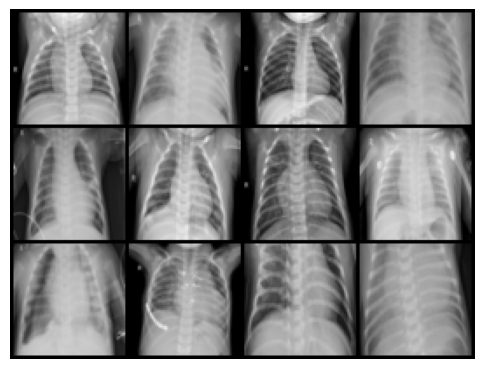

In [ ]:
# Load dataset with torchvision.datasets.ImageFolder and define transforms
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

IMG_SIZE = 64  # change to 128 for higher fidelity (slower)
data_root = './data/chest_xray'

# Transforms for GAN pipeline: [0,1] tensors then map to [-1,1] when training the GAN
transform_gan = T.Compose([
    T.Grayscale(num_output_channels=1), # ensure single channel
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),                       # converts to [0,1]
])

# Transforms for classifier (we will resize to 224 later when training ResNet)
transform_base = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
])

train_ds = datasets.ImageFolder(os.path.join(data_root,'train'), transform=transform_gan)
val_ds   = datasets.ImageFolder(os.path.join(data_root,'val'), transform=transform_gan)
test_ds  = datasets.ImageFolder(os.path.join(data_root,'test'), transform=transform_gan)

print('Classes (train):', train_ds.classes)
print('Train size:', len(train_ds), 'Val size:', len(val_ds), 'Test size:', len(test_ds))

# Visualize some samples
def show_grid(dataset, n=12):
    idxs = np.random.choice(len(dataset), n, replace=False)
    imgs = [dataset[i][0] for i in idxs]
    grid = torchvision.utils.make_grid(torch.stack(imgs), nrow=4, normalize=True)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.show()

show_grid(train_ds, n=12)

# Explanation:
# - We use Grayscale to ensure consistency.
# - For GAN training we will map images to [-1,1] before feeding to the discriminator.
# - show_grid uses torchvision.utils.make_grid for a quick visual sanity check.


## Part 5 — DCGAN Theory (deep lecture)

**What is a GAN?** Generative Adversarial Networks (GANs) consist of two neural networks trained simultaneously: a Generator (G) and a Discriminator (D). G tries to produce realistic images from noise; D attempts to distinguish real from fake images. The two networks play a minimax game.

**Loss intuition:** For binary cross-entropy GAN:

- D is trained to maximize `log D(x)` for real `x` and `log (1 - D(G(z)))` for fake images.
- G is trained to maximize `log D(G(z))` (i.e., fool D).

**Why DCGAN?** DCGAN uses convolutional and transposed convolutional layers which are suitable for image data. The architecture choices (BatchNorm, ReLU in G, LeakyReLU in D, Tanh output) come from the DCGAN paper which found these to be stable choices.

**Important practical notes:**
- Normalize images to [-1,1] to match `tanh` output of G.
- Use `Adam` optimizer with `lr=2e-4`, `beta1=0.5` for stability.
- Monitor sample grids rather than only losses.

Below we provide a fully commented DCGAN implementation (generator, discriminator, weight init, and training loop).

Using device: cuda


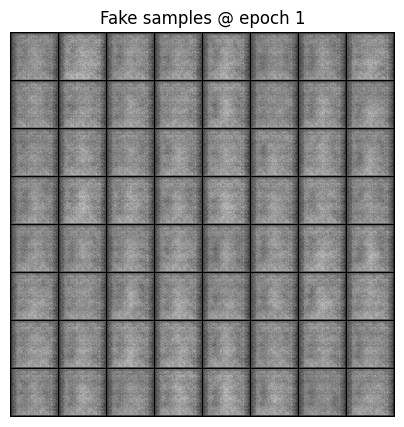

Epoch 1/5 | Loss D: 0.5593 | Loss G: 25.3060


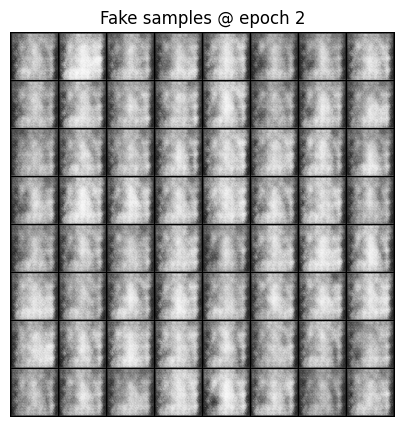

Epoch 2/5 | Loss D: 2.8784 | Loss G: 14.7074


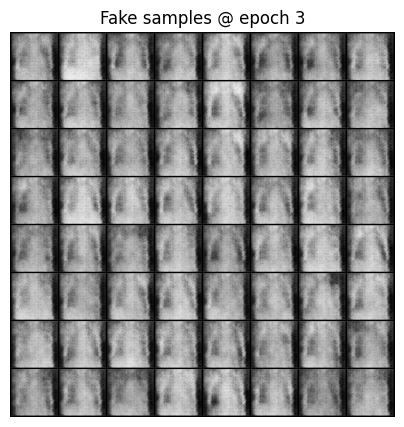

Epoch 3/5 | Loss D: 1.0373 | Loss G: 8.7532


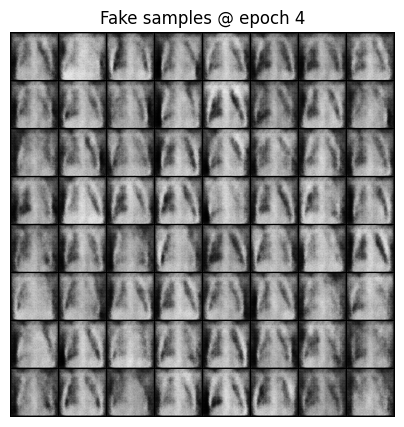

Epoch 4/5 | Loss D: 2.2644 | Loss G: 2.8922


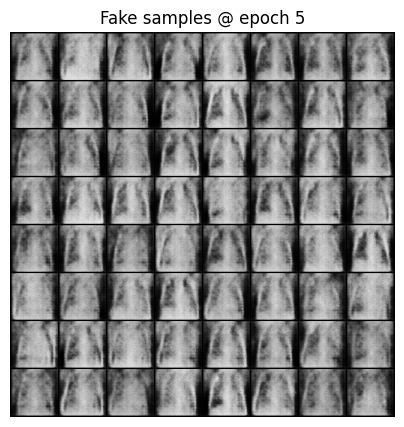

Epoch 5/5 | Loss D: 0.9249 | Loss G: 2.1797
DCGAN training complete (demo). Checkpoints saved in ./checkpoints


In [ ]:

# DCGAN implementation with detailed comments explaining each line.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Hyperparameters (editable by instructor)
nz = 64          # latent vector size (dimensionality of noise z)
ngf = 64         # base number of generator feature maps
ndf = 64         # base number of discriminator feature maps
nc = 1           # number of channels in generated images (1 for grayscale)
IMG_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Generator: transforms a noise vector z into a synthetic image using ConvTranspose (deconvolution) layers.
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # The architecture upsamples from 1x1 to IMG_SIZE x IMG_SIZE via several ConvTranspose2d layers.
        self.model = nn.Sequential(
            # Input: latent vector z of shape (nz,1,1) -> output (ngf*8 x 4 x 4)
            nn.ConvTranspose2d(nz, ngf*8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # (ngf*8 x 4 x 4) -> (ngf*4 x 8 x 8)
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # (ngf*4 x 8 x 8) -> (ngf*2 x 16 x 16)
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # (ngf*2 x 16 x 16) -> (ngf x 32 x 32)
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # (ngf x 32 x 32) -> (nc x 64 x 64) final output
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()  # outputs in range [-1,1]
        )
    def forward(self, z):
        # z expected shape: (batch_size, nz, 1, 1)
        return self.model(z)

# Discriminator: classifies images as real or fake using conv layers that downsample spatially.
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Input: (nc x 64 x 64) -> (ndf x 32 x 32)
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf x 32 x 32) -> (ndf*2 x 16 x 16)
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*2 x 16 x 16) -> (ndf*4 x 8 x 8)
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*4 x 8 x 8) -> (ndf*8 x 4 x 4)
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # Final conv to 1x1 -> output probability via Sigmoid
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        # Return flattened logits (batch_size,)
        return self.model(x).view(-1)

# Initialize networks and weights
G = Generator().to(device)
D = Discriminator().to(device)

# Weight initialization as recommended in DCGAN paper: Normal(0,0.02)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G.apply(weights_init)
D.apply(weights_init)

# Setup criterion and optimizers
criterion = nn.BCELoss()  # Binary Cross-Entropy for GAN standard
lr = 2e-4
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

# Prepare dataloader for GAN: map images [0,1] -> [-1,1] for tanh
from torch.utils.data import DataLoader

def to_gan_range(x):
    # Map [0,1] to [-1,1]
    return x * 2.0 - 1.0

gan_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

# Training loop (short demo: EPOCHS = 5 for workshop demonstration)
EPOCHS = 5
fixed_noise = torch.randn(64, nz, 1, 1, device=device)  # fixed for monitoring progress

for epoch in range(1, EPOCHS+1):
    G.train(); D.train()
    for real in gan_loader:
        # real is a batch of images (batch_size, 1, H, W)
        real = to_gan_range(real[0]).to(device)  # map to [-1,1] and move to device
        bsz = real.size(0)

        # --------------- Train Discriminator ---------------
        D.zero_grad()
        # Labels
        label_real = torch.full((bsz,), 1.0, device=device)  # real label = 1
        label_fake = torch.full((bsz,), 0.0, device=device)  # fake label = 0

        # D on real images
        out_real = D(real)
        lossD_real = criterion(out_real, label_real)

        # Generate fake images
        noise = torch.randn(bsz, nz, 1, 1, device=device)
        fake = G(noise)
        out_fake = D(fake.detach())  # detach so gradients don't flow to G
        lossD_fake = criterion(out_fake, label_fake)

        # Combined discriminator loss and update
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # --------------- Train Generator ---------------
        G.zero_grad()
        # We want D(G(z)) to be labeled as real (1) to fool D
        out_fake_forG = D(fake)
        lossG = criterion(out_fake_forG, label_real)
        lossG.backward()
        optimizerG.step()

    # Visualize progress: generate samples from fixed_noise
    G.eval()
    with torch.no_grad():
        samples = (G(fixed_noise).cpu() * 0.5) + 0.5  # map to [0,1] for display
        grid = torchvision.utils.make_grid(samples, nrow=8, padding=2)
        plt.figure(figsize=(5,5)); plt.axis('off'); plt.title(f'Fake samples @ epoch {epoch}')
        plt.imshow(grid.permute(1,2,0)); plt.show()

    print(f'Epoch {epoch}/{EPOCHS} | Loss D: {lossD.item():.4f} | Loss G: {lossG.item():.4f}')

# Save checkpoints
os.makedirs('checkpoints', exist_ok=True)
torch.save(G.state_dict(), 'checkpoints/dcgan_G.pth')
torch.save(D.state_dict(), 'checkpoints/dcgan_D.pth')
print('DCGAN training complete (demo). Checkpoints saved in ./checkpoints')

## Part 7 — VAE Theory (deep lecture)

Variational Autoencoders (VAEs) are probabilistic generative models. They consist of an encoder that maps input x to a latent distribution q(z|x) parameterized by (μ, σ²), and a decoder p(x|z). The reparameterization trick samples z = μ + σ * ε, which enables backpropagation.

Loss = Reconstruction Loss + KL Divergence

- Reconstruction (e.g. BCE or MSE) measures how well decoder reconstructs input.
- KL term forces q(z|x) to be close to prior p(z) (usually N(0,I)).

VAEs produce smoother latent spaces than GANs and are excellent for controlled variations (appearance augmentation).

In [ ]:

# VAE implementation (small conv-VAE) with detailed comments.
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, zdim=32):
        super().__init__()
        # Encoder: conv layers to reduce spatial size and increase channels
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # -> 32 x 32 x 32 (if IMG_SIZE=64)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # -> 64 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),# -> 128 x 8 x 8
            nn.ReLU(),
        )
        # Flatten and linear layers for mean and log-variance
        self.fc_in = nn.Linear(128 * 8 * 8, 512)
        self.fc_mu = nn.Linear(512, zdim)
        self.fc_logvar = nn.Linear(512, zdim)
        # Decoder: mirror the encoder
        self.fc_dec = nn.Linear(zdim, 128 * 8 * 8)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # -> 64 x 16 x 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # -> 32 x 32 x 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),   # -> 1 x 64 x 64
            nn.Sigmoid()  # outputs in [0,1] for reconstruction
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        h = F.relu(self.fc_in(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick: sample eps ~ N(0,1)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc_dec(z))
        h = h.view(h.size(0), 128, 8, 8)
        out = self.dec(h)
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

# Training VAE (short demo)
vae = VAE(zdim=64).to(device)
opt = optim.Adam(vae.parameters(), lr=1e-3)

def vae_loss(recon, x, mu, logvar):
    # Reconstruction loss (BCE) + KL divergence
    recon_loss = F.binary_cross_entropy(recon, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

vae_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

for epoch in range(3):  # small number of epochs for demo
    vae.train()
    total = 0.0
    for xb in vae_loader:
        x = xb[0].to(device)
        out, mu, logvar = vae(x)
        loss = vae_loss(out, x, mu, logvar)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()
    print(f'VAE epoch {epoch+1} loss: {total/len(vae_loader):.4f}')

# Save VAE
torch.save(vae.state_dict(), 'checkpoints/vae.pth')
print('VAE training (demo) complete.')


VAE epoch 1 loss: 165173.1786
VAE epoch 2 loss: 158398.4435
VAE epoch 3 loss: 156692.7687
VAE training (demo) complete.


## Part 9 — Latent interpolation & generating variations

We can sample different z for the VAE and GAN, and interpolate between two latent vectors to create smooth transitions between images. This is useful to create middle-ground examples or increase diversity.

In [ ]:

# Latent interpolation examples for GAN and VAE
import torchvision

# 1) GAN interpolation in latent space (mix two noise vectors)
os.makedirs('synthetic_interpol_gan', exist_ok=True)
with torch.no_grad():
    z1 = torch.randn(1, nz, 1, 1, device=device)
    z2 = torch.randn(1, nz, 1, 1, device=device)
    for i,alpha in enumerate([0.0,0.25,0.5,0.75,1.0]):
        z = alpha*z1 + (1-alpha)*z2
        img = (G(z).cpu() * 0.5) + 0.5
        torchvision.utils.save_image(img, f'synthetic_interpol_gan/interp_{i}.png')

# 2) VAE interpolation using means
os.makedirs('synthetic_interpol_vae', exist_ok=True)
vae.eval()
with torch.no_grad():
    # pick two images from train_ds
    x1,_ = train_ds[0]
    x2,_ = train_ds[1]
    x1 = x1.unsqueeze(0).to(device); x2 = x2.unsqueeze(0).to(device)
    mu1, lv1 = vae.encode(x1); mu2, lv2 = vae.encode(x2)
    for i,alpha in enumerate([0.0,0.25,0.5,0.75,1.0]):
        z = alpha*mu1 + (1-alpha)*mu2
        dec = vae.decode(z)
        torchvision.utils.save_image(dec.cpu(), f'synthetic_interpol_vae/interp_{i}.png')

print('Saved interpolation images for GAN and VAE.')

Saved interpolation images for GAN and VAE.


## Part 10 — ResNet Theory (deep lecture)

Residual Networks (ResNets) introduced skip connections to mitigate vanishing gradients and enable very deep networks. A residual block learns the residual function F(x) such that the block output is x + F(x). This makes optimization easier.

Why use ResNet18 for medical imaging?
- Good balance of depth and speed
- Pretrained weights transfer useful low-level features
- Skip connections help train stably

We will adapt ResNet18 to accept 1-channel X-ray images by modifying the first convolutional layer.

In [ ]:

# ResNet18 training and evaluation with detailed comments
import timm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms as T, datasets

# Prepare dataset for ResNet: higher resolution (224) and batch size suitable for GPU
RES_IMG = 224
batch_size = 32

transform_train = T.Compose([
    T.Grayscale(num_output_channels=1),  # ensure single-channel input
    T.Resize((RES_IMG, RES_IMG)),
    T.ToTensor(),
])

transform_eval = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize((RES_IMG, RES_IMG)),
    T.ToTensor(),
])

train_ds_res = datasets.ImageFolder(os.path.join(data_root,'train'), transform=transform_train)
val_ds_res   = datasets.ImageFolder(os.path.join(data_root,'val'), transform=transform_eval)
test_ds_res  = datasets.ImageFolder(os.path.join(data_root,'test'), transform=transform_eval)

train_loader_res = DataLoader(train_ds_res, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader_res = DataLoader(val_ds_res, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader_res = DataLoader(test_ds_res, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Load pretrained ResNet18 and adapt first conv for 1-channel images
model_res = timm.create_model('resnet18', pretrained=True, num_classes=2)
# Replace first convolutional layer (original expects 3 channels)
model_res.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_res = model_res.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_res.parameters(), lr=1e-4)

# Training and evaluation loops with detailed comments
def train_epoch_res(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    preds=[]; gts=[]
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds.extend(out.argmax(1).cpu().numpy())
        gts.extend(yb.cpu().numpy())
    acc = (np.array(preds) == np.array(gts)).mean()
    return total_loss/len(loader), acc

def eval_res(model, loader):
    model.eval()
    preds=[]; gts=[]
    with torch.no_grad():
        for xb,yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds.extend(out.argmax(1).cpu().numpy())
            gts.extend(yb.cpu().numpy())
    acc = (np.array(preds) == np.array(gts)).mean()
    return acc, confusion_matrix(gts, preds), classification_report(gts, preds, target_names=loader.dataset.classes)

# Quick baseline train for a few epochs
for epoch in range(3):
    loss, acc = train_epoch_res(model_res, train_loader_res, optimizer, criterion)
    val_acc, cm, cr = eval_res(model_res, val_loader_res)
    print(f'Epoch {epoch+1} | Train loss {loss:.4f} | Train acc {acc:.4f} | Val acc {val_acc:.4f}')
    print('Classification report (val):\n', cr)
# Save model
torch.save(model_res.state_dict(), 'checkpoints/resnet18_baseline.pth')
print('Saved ResNet baseline.')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Epoch 1 | Train loss 0.3112 | Train acc 0.8792 | Val acc 0.5625
Classification report (val):
               precision    recall  f1-score   support

      NORMAL       1.00      0.12      0.22         8
   PNEUMONIA       0.53      1.00      0.70         8

    accuracy                           0.56        16
   macro avg       0.77      0.56      0.46        16
weighted avg       0.77      0.56      0.46        16

Epoch 2 | Train loss 0.1014 | Train acc 0.9670 | Val acc 0.5625
Classification report (val):
               precision    recall  f1-score   support

      NORMAL       1.00      0.12      0.22         8
   PNEUMONIA       0.53      1.00      0.70         8

    accuracy                           0.56        16
   macro avg       0.77      0.56      0.46        16
weighted avg       0.77      0.56      0.46        16

Epoch 3 | Train loss 0.0534 | Train acc 0.9822 | Val acc 0.6875
Classification report (val):
               precision    recall  f1-score   support

      NOR

## Part 11 — AR Demo (MediaPipe) — Why Colab requires snapshot loop

Colab cannot open a continuous webcam stream in the browser for security reasons. The recommended approach is a fast repeated snapshot method that mimics video. Below is the live loop with detailed comments.

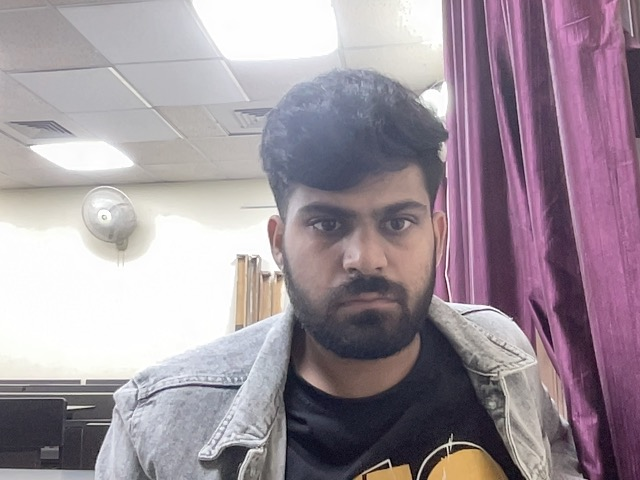

/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


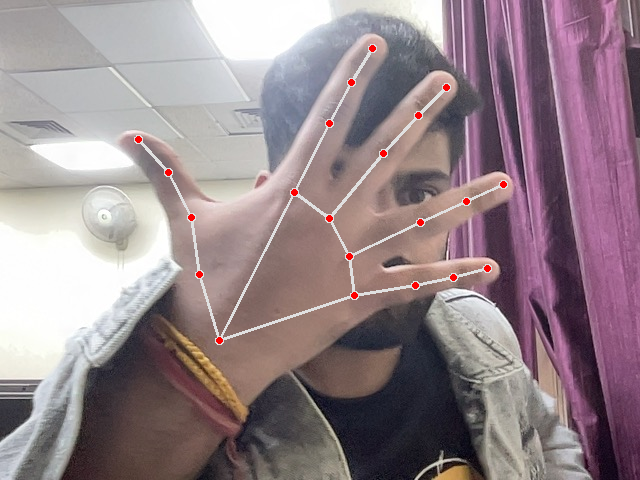

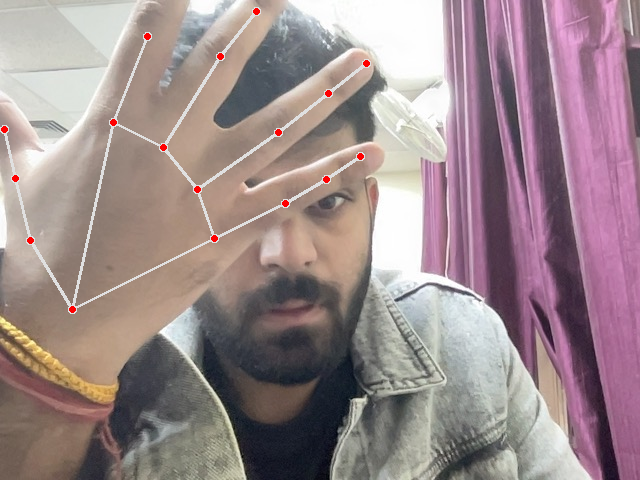

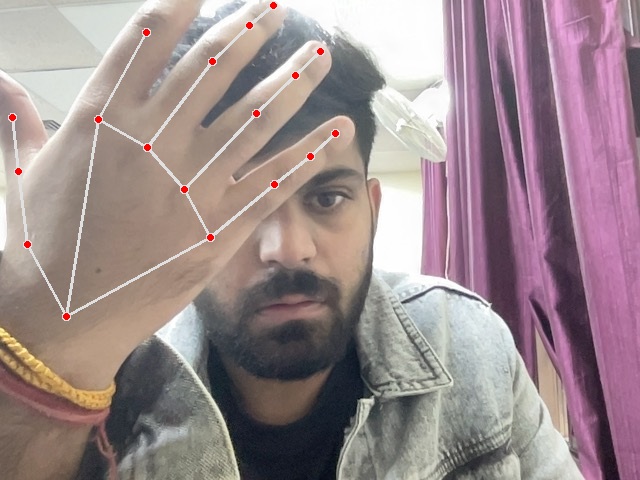

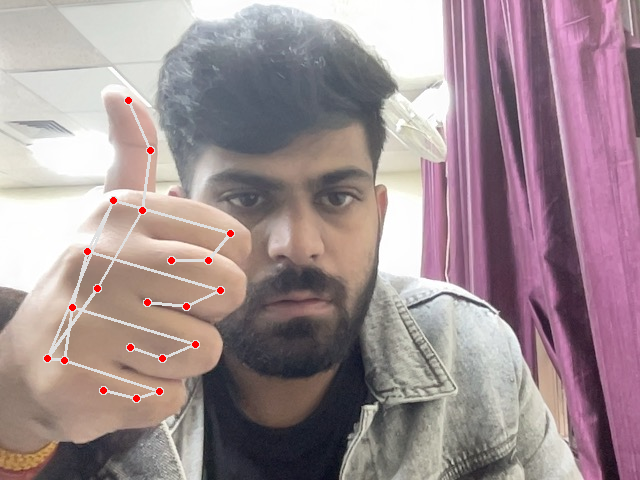

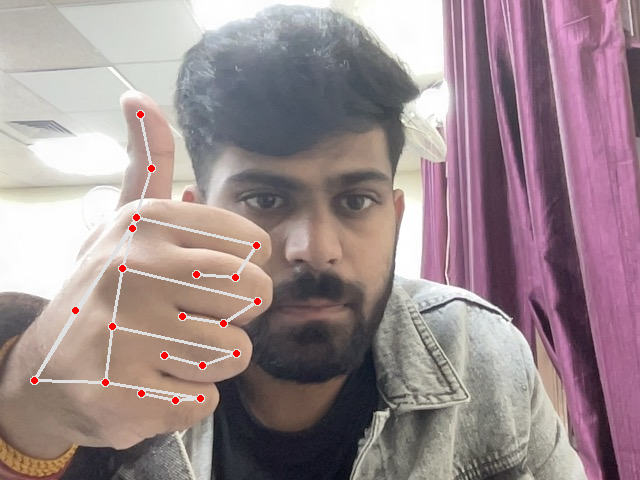

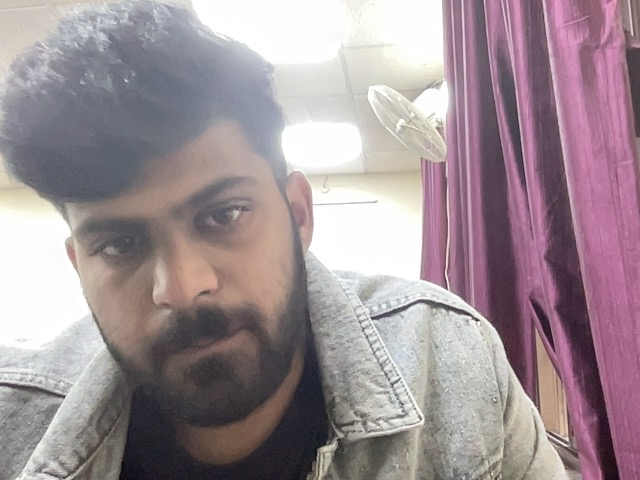

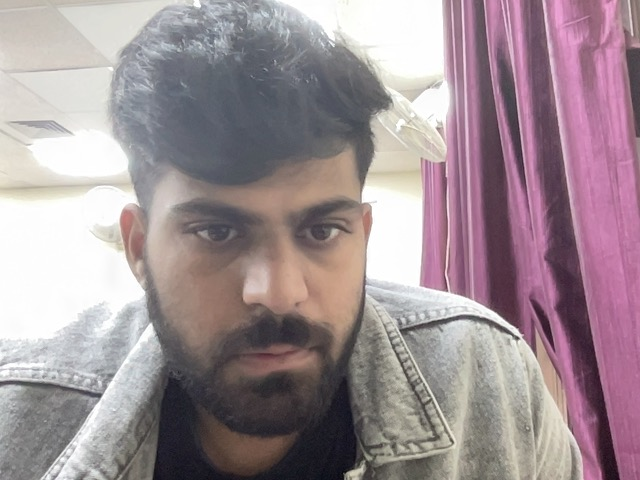

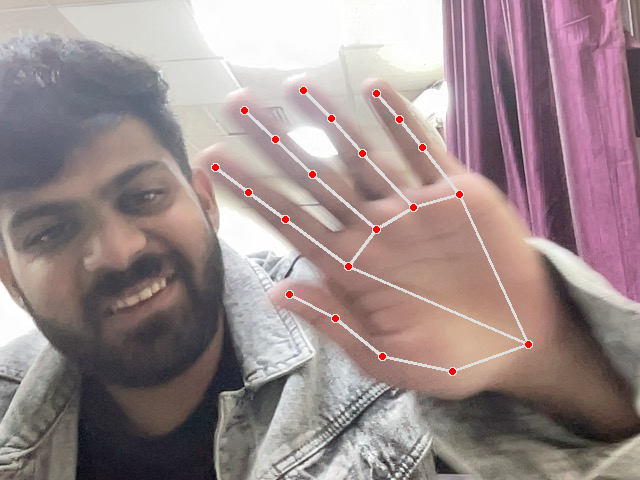

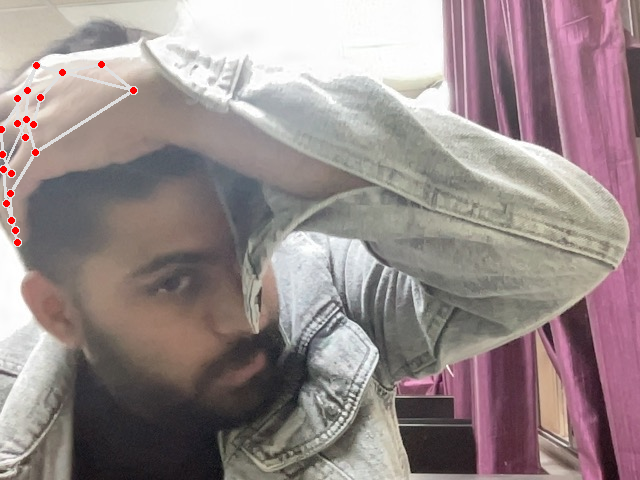

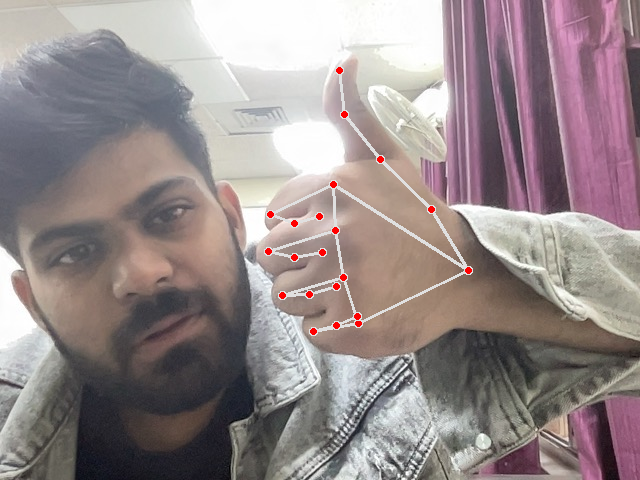

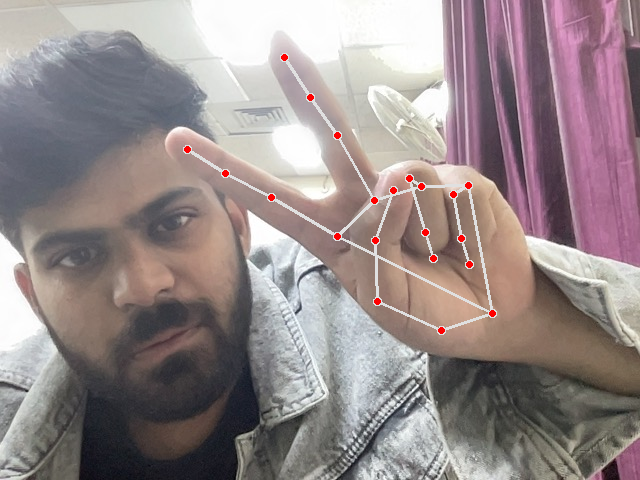

In [ ]:
#Live AR loop for Colab using JS snapshots and MediaPipe (hands)
from google.colab import output
from base64 import b64decode
import cv2, numpy as np, mediapipe as mp, time
from google.colab.patches import cv2_imshow

mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

def js_capture():
    # JavaScript code executed in browser context to capture one frame from webcam
    js = '''
    async function takePhoto() {
      const video = document.createElement('video');
      video.style.display = 'none';
      document.body.appendChild(video);
      const stream = await navigator.mediaDevices.getUserMedia({video:true});
      video.srcObject = stream;
      await video.play();
      await new Promise(resolve => setTimeout(resolve, 200));
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(t => t.stop());
      const dataURL = canvas.toDataURL('image/jpeg');
      return dataURL;
    }
    takePhoto();
    '''
    data = output.eval_js(js)
    img_bytes = b64decode(data.split(',')[1])
    img = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_COLOR)
    return img

# Capture a sequence of frames and process them with MediaPipe
with mp_hands.Hands(max_num_hands=2, min_detection_confidence=0.5) as hands:
    for i in range(12):  # capture 12 frames
        img = js_capture()
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        res = hands.process(rgb)
        if res.multi_hand_landmarks:
            for hand in res.multi_hand_landmarks:
                mp_draw.draw_landmarks(img, hand, mp_hands.HAND_CONNECTIONS)
        cv2_imshow(img)
        time.sleep(0.25)


## Part 12 — Results visualization (t-SNE / UMAP) and teaching notes

We recommend extracting penultimate-layer features from ResNet and running t-SNE/UMAP to compare real vs synthetic distributions. This cell provides a template; adapt the feature extraction based on how the model exposes features (e.g., `forward_features`).

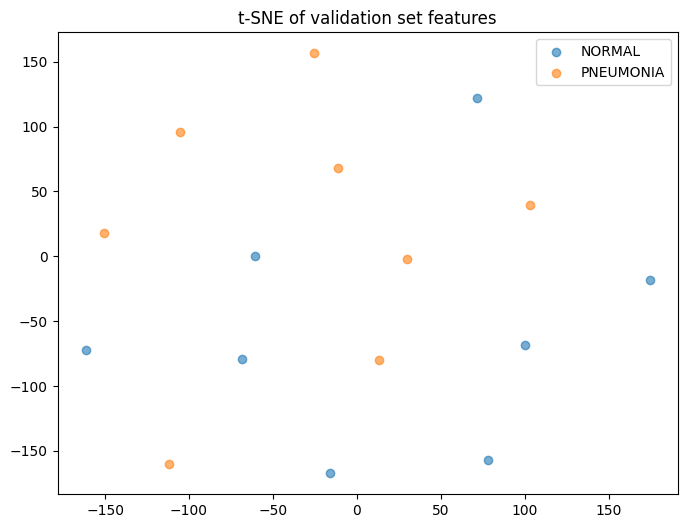

In [ ]:

# t-SNE / embedding visualization template
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Example: extract embeddings from a sample of validation set using model_res up to penultimate layer.
# If model has `forward_features`, use it; otherwise, you may rebuild a feature extractor.
def extract_features(model, loader, max_samples=500):
    model.eval()
    feats=[]; labs=[]
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            # Try model.forward_features for timm models; fallback to model(xb) before fc
            if hasattr(model, 'forward_features'):
                f = model.forward_features(xb)
                f = f.mean(dim=[2,3]) if f.ndim==4 else f
            else:
                # simple forward and remove final fc by slicing
                out = model(xb)
                f = out.detach().cpu().numpy()
            feats.append(f.cpu().numpy() if isinstance(f, torch.Tensor) else f)
            labs.extend(yb.numpy())
            if len(labs) >= max_samples:
                break
    feats = np.concatenate(feats, axis=0)[:max_samples]
    labs = np.array(labs[:max_samples])
    return feats, labs

# Run t-SNE
feats, labs = extract_features(model_res, val_loader_res, max_samples=400)
tsne = TSNE(n_components=2, perplexity=15, random_state=42).fit_transform(feats)
plt.figure(figsize=(8,6))
for cls in np.unique(labs):
    idx = labs==cls
    plt.scatter(tsne[idx,0], tsne[idx,1], label=val_loader_res.dataset.classes[cls], alpha=0.6)
plt.legend(); plt.title('t-SNE of validation set features'); plt.show()


## Final Notes, Ethics, and Next Steps

- **Ethics:** Synthetic medical images are for research/augmentation only. Clinical claims require expert validation and regulated trials.
- **Validation:** Have radiologists review synthetic samples; compute FID/KID for distributional similarity if needed.
- **Extensions:** cGAN for class-conditional generation, diffusion models for higher fidelity, inpainting for lesion insertion.



# Task
Resolve conflicting Python package dependencies (numpy, mediapipe, torch, torchvision) and then continue the notebook execution, starting with the data loading and transformation cells.

## uninstall_and_reinstall_dependencies

### Subtask:
Force uninstall numpy, torch, torchvision, and mediapipe to clear conflicting installations. Then install numpy==1.24.4, followed by a force reinstall of torch and torchvision, and finally install mediapipe along with other required packages.


**Reasoning**:
The subtask requires uninstalling problematic packages and then reinstalling them with specific versions and orders to resolve dependency conflicts. This code block executes all the necessary pip commands to achieve this.

